### Locality-Sensitive Hashing

I first heard about _locality-sensitive hashing_ (LSH) while taking the Coursera class __Mining Massive Datasets__.  I found it confusing and counter-intuitive, and therefore fascinating.  The basic idea behind LSH is that the hash value of two data items can be compared to give an estimate of the similarity between the original items, but there's not much about the typical notion of hashing that suggests this is possible.

We know that a hash function is a function that takes a variable length input, like maybe a text document, and turns it into a fixed-length output.  As a programmer the idea of a hash brings to mind two things: the hash functions used for hash tables, and cryptographic hashes; neither of which make you think of similarity.

For example you'd expect that the hash function in Python would give you a good uniform distribution of keys, because that's want you want for a hash table.  But you don't expect that similar inputs will necessarily give you similar hash values.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

list(map(lambda x: hash(x), ('john smith', 'john smyth', 'john smythe')))

[3902745866313186956, -5792825150175209561, -2715593420020542310]

And of course with a cryptographic hash it's _essential_ that similar data not give similar hash values.   

In [20]:
import hashlib
(hashlib.md5('when in the course of human events'.encode('utf-8')).hexdigest(),
 hashlib.md5('when in the course of human events it'.encode('utf-8')).hexdigest())

('f5c8c961556a008b2393f09bba35f9b3', '182da9669648b14bdbef9abb5d076076')

The _idea_ of LSH seems to have originated in Andrei Broder's 1997 paper _On the Resemblance and Containment of Documents_, although he never used the term.  Broder was concerned with the problem of finding similar web pages.  He used a metric for document similarity defined like:

$$
r(A,B) = \frac{|S(A,k) \cap S(B,k)|}{|S(A,k) \cup S(B,k)|}
$$

where S(A,k) is the set of length k _shingles_ of document A.  A _shingle_ here is a set of contigous tokens, for example: 

In [21]:
# N-gram function courtesy of Peter Norvig
def ngrams(seq, n):
    "List all the (overlapping) ngrams in a sequence."
    return [seq[i:i+n] for i in range(1+len(seq)-n)]

doc1 = "Happy families are all alike; every unhappy family is unhappy in its own way"
ngrams(doc1.split(), 3)

[['Happy', 'families', 'are'],
 ['families', 'are', 'all'],
 ['are', 'all', 'alike;'],
 ['all', 'alike;', 'every'],
 ['alike;', 'every', 'unhappy'],
 ['every', 'unhappy', 'family'],
 ['unhappy', 'family', 'is'],
 ['family', 'is', 'unhappy'],
 ['is', 'unhappy', 'in'],
 ['unhappy', 'in', 'its'],
 ['in', 'its', 'own'],
 ['its', 'own', 'way']]

The shingles are important in the application of comparing documents because they reduce the likelihood that two documents will seem similar just because they share many individual words.  However, in what follows you can just think of the shingles as the _things_ that make up a set, in which case the measure above is just _set similarity_ or _Jaccard similarity_.  The arguments below apply as well to individual tokens or even numbers.

Let &Omega; be the set of all things (eg, shingles) in all documents.

$$
W \subset \Omega
$$

$$
MIN_{s}(W) = \mbox{the set of smallest s elements in W}
$$

Of course _smallest_ implies that &Omega; is ordered.  For numbers or tokens there's a natural way to do that, but we can generally assume that &Omega; is ordered and that this ordering determines what is smallest in W.

Now suppose that we have a function &pi; that defines a permutation on &Omega;. For example, say that &Omega; is the set of lower-case letters:

In [22]:
import string
import random

p = list(range(len(string.ascii_lowercase)))
random.shuffle(p)

def permute(w, p):
    return ''.join(string.ascii_lowercase[p[ord(c) - ord('a')]] for c in w)

print(string.ascii_lowercase)
print(permute(string.ascii_lowercase, p))

abcdefghijklmnopqrstuvwxyz
pxsgiwdqlbaunrmtyoefhkcjzv


Note that in what follows, when i refer to a _permutation_ i mean applying the permute function (ie &pi;) to a set of items.  This might be perfectly obvious but when i first looked at LSH i was confused by this terminology.

Next we will create some "documents" built from the items in &Omega; (in other words some characters strings).  We also make a function that measures the similarity between sets:

In [23]:
def jaccard_similarity(a, b):
    x = set(a)
    y = set(b)
    return len(x & y) / len(x | y)

d1 = 'allhappyfamiliesarealike'
d2 = 'rarehippofamiliesridebikes'
d3 = 'bewarethejabberwock'
s1 = list(set(d1))
s2 = list(set(d2))
s3 = list(set(d3))
print(''.join(s1),''.join(s2),''.join(s3))
print (permute(s1, p), permute(s2, p), permute(s3,p))
print (jaccard_similarity(d1, d2), jaccard_similarity(s1, s2) ,jaccard_similarity(permute(s1, p), permute(s2, p)))
print (jaccard_similarity(d1, d3), jaccard_similarity(s1, s3) ,jaccard_similarity(permute(s1, p), permute(s3, p)))

prhymkelaisf rphmkedlbaisfo rhkebjatwoc
toqznaiuplew otqnaiguxplewm oqaixbpfcms
0.7333333333333333 0.7333333333333333 0.7333333333333333
0.2777777777777778 0.2777777777777778 0.2777777777777778


Above we have three documents (d1,d2,d2), and we first reduce these to sets of unique elements (s1,s2,s2) for simplicity (Broder's technique also works with multisets).  Notice that the Jaccard similarity of the original strings, the reduced sets, and permutations of the reduced sets are all the same.

The paper next defines a function M for each document:

$$
M(A) = MIN_{s}(\pi(S(A,k)))
$$

but since we're ignoring the shingling, we'll just use

$$
M(A) = MIN_{s}(\pi(A))
$$

Note that the _M_ function takes a document and reduces it to a fixed-length (=s) representation, so this is a hash function.  More on that later.

In [24]:
def m(w, s, p):
    return sorted(permute(w, p))[:s]
    
(m(s1, 6, p),
m(s2, 6, p),
m(s3, 6, p))

(['a', 'e', 'i', 'l', 'n', 'o'],
 ['a', 'e', 'g', 'i', 'l', 'm'],
 ['a', 'b', 'c', 'f', 'i', 'm'])

The key insight in the paper is that

$$
\frac{|MIN_{s}(M(A) \cup M(B)) \cap M(A) \cap M(B)|}{|MIN_{s}(M(A) \cup M(B))|}
$$

is an _unbiased estimator_ of the resemblance of A and B.  This just means that the value is a statistic for which the expected value is the true value of the resemblance.

If you're like me, it's probably not immediately apparent why this is.  To clarify, we'll look at both the proof offered by Broder and some specific cases.  First, we'll consider the estimator in two different parts:

$$
MIN_{s}(M(A) \cup M(B))
$$

which is in both the numerator and denominator, and

$$
M(A) \cap M(B)
$$

The paper shows that the first term is equal to

$$
MIN_{s}(\pi(A \cup B))
$$

Now suppose that the minimum element of the latter expression is &alpha;.  Since it's the minimum element of the permutation of the union, it's also going to be the minimum element of either M(A) or M(B).  If the character that &alpha; permuted from (&pi;<sup>-1</sup>(&alpha;)) is in the _intersection_ of A and B then &alpha; will be the minimum value in both M(A) and M(B) and so will be in the second term.  So if you put that all together you get that:

$$
\begin{align}
Pr(\alpha \in M(a) \cap M(B)) &= Pr(\pi^{-1}(\alpha) \in A \cap B) \\
&= \frac{|A \cap B|}{|A \cup B|}
\end{align}
$$

In other words, the probability that &alpha; is in M(A) intersection M(B) is equal to the set resemblance.  Note that if s=1, this means that Pr(M(A) = M(B)) is equal to the set resemblance, which will be useful later. 

Imagine a simple case where A is {a,b,c,d,e} and B is {a,b,c,d,f}, so that the union is {a,b,c,d,e,f} and the intersection is {a,b,c,d}.  if you choose a random element from the union, there's a 2/3 probability that the element is also in the intersection, which is also the value of the set resemblance.  Applying a permutation to the union is sort of like applying a new sort order to the original elements, and we assume that any element now has an equal probability of being the minimum element.  As a result we'd expect the size of the set in the numerator to be 2/3 the size of the set in the denominator given a large enough sample or enough permutations.

As you can see below, this doesn't mean that one value for this calculation will give us the correct answer:

In [25]:
def estimator(d1, d2, s, p):
    ma = set(m(d1, s, p))
    mb = set(m(d2, s, p))

    mab = set(sorted(list(ma | mb))[:s])
    return len(mab & ma & mb)/len(mab)

estimator(s1, s2, 6, p), estimator(s1, s3, 6, p)

(0.6666666666666666, 0.3333333333333333)

However, it does mean that if we have larger samples (larger value for s) or more permutations, we should get closer to the right answer:

0.7166666666666667 0.25833333333333336
0.7283333333333332 0.2683333333333333


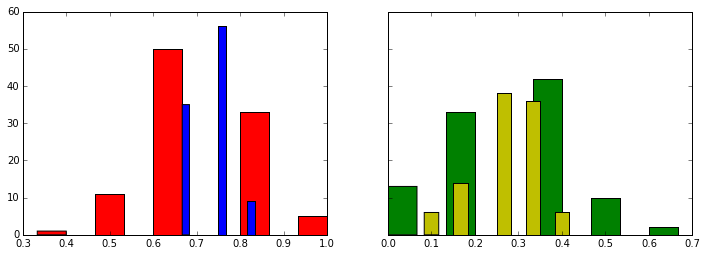

In [26]:
NUM_PERMUTATIONS = 100
rps = []
for i in range(NUM_PERMUTATIONS):
    random.shuffle(p)
    rps.append(p.copy())
    
est1 = [estimator(s1, s2, 6, rp) for rp in rps]
est2 = [estimator(s1, s3, 6, rp) for rp in rps]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
ax1.hist(est1, color='r')
ax2.hist(est2, color='g')
print(sum(est1)/NUM_PERMUTATIONS, sum(est2)/NUM_PERMUTATIONS)

est1 = [estimator(s1, s2, 12, rp) for rp in rps]
est2 = [estimator(s1, s3, 12, rp) for rp in rps]

_=ax1.hist(est1, color='b')
_=ax2.hist(est2, color='y')
print(sum(est1)/NUM_PERMUTATIONS, sum(est2)/NUM_PERMUTATIONS)

These histograms show the value for the estimator over 100 permutations, with s=6 and s=12.  The left graph is the estimate of similarity for s1 and s2 while the right graph is the for s1 and s3.  You can see that that values get both closer to the actual value and less dispersed with larger samples; however the average value of the estimator is close in both cases.

Note that we can even do this with s=1.  In this case the proportion of times that the minimum character is the same after the permutation is the estimator.

0.64 0.33


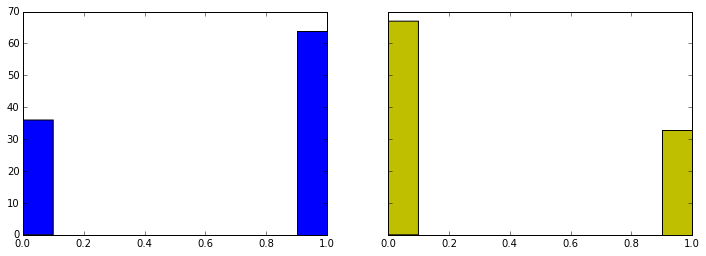

In [27]:
est1 = [estimator(s1, s2, 1, rp) for rp in rps]
est2 = [estimator(s1, s3, 1, rp) for rp in rps]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
_=ax1.hist(est1, color='b')
_=ax2.hist(est2, color='y')
print(sum(est1)/NUM_PERMUTATIONS, sum(est2)/NUM_PERMUTATIONS)

The basic idea here is that we can calculate M(x) for all of the documents in our set, and then we can estimate the similarity of any two documents A and B using M(A) and M(B). This function M(x) has become known as _MinHash_, although Broder never used that name.  In fact, he called M(x) a _sketch_. (Note: I have yet to find the first use of the term MinHash).  In our example, this isn't particularly useful because the value of M(x) is almost as large as the original string.  But the MinHash of the shingles in web page will be much more compact that the original document.

Minhash is also not usually implemented in this way.  First, MinHash now usually means doing multiple permutations and taking the minimum item from each, rather than doing one permutation and keeping _s_ values.  Second, in real situations it can be difficult to generate independent permutations of large sets, and even if you could the sketch itself can be fairly large for sufficiently large values of _s_.  Broder's solution was to reduce the set of shingles to a binary string, and then calculate [_Rabin's fingerprint_](https://en.wikipedia.org/wiki/Rabin_fingerprint) for each bit string.

A common technique is to use another hash function to give the effect of a permutation.  In our simple example, the set &Omega; is just the lowercase letters, but it could be a set of tokens or shingles as in Broder's paper.  A given hash function takes items from that set and maps them to a number.  If you have several hash functions, you can apply them all to an item and you end up with a sketch or _signature_ of that item:

In [28]:
import random

def rand_hash(p):
    a = random.randint(1,p-1)
    b = random.randint(1,p-1)
    def h(x):
        return ((a * x + b) % p) 
    return h

def min_hash_sig(s):
    return [min(h(ord(c) - ord('a')) for c in s) for h in hash_fam]

NUM_HASH = 100
hash_fam = [rand_hash(97) for i in range(NUM_HASH)]

(sum(1 if a==b else 0 for a,b in zip(min_hash_sig(s1), min_hash_sig(s2)))/NUM_HASH,
 sum(1 if a==b else 0 for a,b in zip(min_hash_sig(s1), min_hash_sig(s3)))/NUM_HASH)

(0.69, 0.27)

The first use of the actual term _locality-sensitive hashing_ was apparently in a paper by Indyk and Motwani from 1998.  That paper was primarily concerned with the problem of finding approximate nearest-neighbors in high-dimensional data sets; but it relied on LSH for its algorithm.

Suppose that you have a function _Sim_ that measures the similarity between any two items _d<sub>1</sub>_ and _d<sub>2</sub>_; and a family of hash functions _H_.  What we want in an LSH is that if d1 and d2 are similar according to _Sim_ then there should be a higher probability that any randomly chosen _h_ in H will give the same value for both items, and if d1 and d2 are dissimilar then there should be a lower probability that the value of of _h_ is the same.  Indyk and Motwani formalized that like this:

$$
\mbox{if  } Sim(d_{1}, d_{2}) > s_{1} \mbox{  then  } Pr(h(d_{1}) = h(d_{2})) > p_{1}
$$

$$
\mbox{if  } Sim(d_{1}, d_{2}) < s_{2} \mbox{  then  } Pr(h(d_{1}) = h(d_{2})) < p_{2}
$$

where s1 > s2 and p1 > p2.  If H meets these conditions, then they call it an _(s1, s2, p1, p2)-sensitive_ hash family.  They identify MinHash as an instance of an LSH (though they, too, do not use that term), but it's probably fairly clear that it does meet this definition since we've already seen that the probability that MinHash(d1) = MinHash(d2) is the same as the set resemblance (Jaccard similarity).  Of course, there are other LSH families for other measures, including Hamming distance and l<sub>p</sub> norm.

Generally speaking the applications of LSH that we've seen are for searching large high-dimensional data sets for similar items, for which it's often the case that there's no better solution that just comparing every item; or more precisely the best algorithm is O(N), or linear in N,  where N is the number of items in the set.  The Indyk-Motwani paper showed that with LSH you can implement a sub-linear search, or specifically you can search with

$$
O(N^{-\frac{ln p_{1}}{ln p_{1}/p_{2}}})
$$

evaluations of the hash function, provided that you do some preprocessing.

To illustrate the idea i'm going to use a deduplication example.  The data sets are restaurants from the Fodors and Zagats guides, which i got from [RIDDLE](http://www.cs.utexas.edu/users/ml/riddle/).  In principle to do deduplication you need to compare every element in the set with every other element, so it's an O(N<sup>2</sup>) process.  For large data sets you need some way to reduce the number of comparisons.  Often that involves some sort of _pre-clustering_ that divides the whole set into clusters so that you only have to compare elements within the clusters.  LSH is one good way to do this.

First we'll make a set of all of the character bigrams in the data, and then make a dictionary that maps each bigram to it's position in the sorted order.  We'll use the latter to establish the order in our permuted sets:

In [29]:
with open('fodors.txt') as f:
    r1 = f.readlines()

with open('zagats.txt') as f:
    r2 = f.readlines()
    
NGRAM_SIZE = 2

r = [(item_id, s.rstrip('\n \x02')) for item_id, s in enumerate(r1 + r2)]
all_ngrams = set()
for iid, l in r:
    if l:
        all_ngrams.update(ngrams(l.strip().lower(),NGRAM_SIZE))
        
ngram_order = {g: i for i,g in enumerate(sorted(list(all_ngrams)))}

The approach is to make a key for each element of the set from a number of MinHash-like functions.  We'll use that for the key into a dictionary of lists.  We expect that if there are duplicate elements, they will be in these sublists.  However, there is a small chance that a given set of MinHash permutations won't catch the duplicates, so we'll also make multiple dictionaries

In [30]:
from collections import defaultdict

NUM_HASH = 2
NUM_GROUPS = 10

def group_key(s, omega, lsh_fam):
    return frozenset([min([h(x) for x in [omega[ng] for ng in ngrams(s.lower(),NGRAM_SIZE)]]) for h in lsh_fam])


def make_group(items, omega):
    grp = defaultdict(list)

    hash_fn = [rand_hash(5099) for i in range(NUM_HASH)]

    for item_id, s in items:
        if s:
            k = group_key(s, omega, hash_fn)

        grp[k].append((item_id,s))
    return grp, hash_fn

grps = [make_group(r, ngram_order) for _ in range(NUM_GROUPS)]

One case of a duplicate in this set is the following restaurant, which has a bigram set similarity of 0.9375.

In [31]:
dupes1 = [item for item in r if 'Veni Vidi' in item[1]]
dd1_id, dd1_name = dupes1[0]
dd2_id, dd2_name = dupes1[1]

(dd1_id, dd1_name,
 dd2_id, dd2_name,
 jaccard_similarity(ngrams(dd1_name.lower(), NGRAM_SIZE), ngrams(dd2_name.lower(), NGRAM_SIZE)))

(397,
 'Veni Vidi Vici 41 14th St. Atlanta 404/875-8424 Italian',
 812,
 'Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian',
 0.9375)

Now that we've made our groups, we can look for duplicates by searching within the smaller groups rather than the whole set.  For this example, the two items are so similar that we'd expect them to be under the same key in most if not all groups.

In [32]:
def most_similar(ts_id, ts, ngram_order, grps, top=10):
    sims = []
    for grp,hf in grps:
        gk = group_key(ts, ngram_order, hf)
        print('Group Size={0}'.format(len(grp[gk])))
        for item_id, s in grp[gk]:
            if ts_id == item_id: continue
            sims += [(s, jaccard_similarity(ngrams(ts.lower(), NGRAM_SIZE), ngrams(s.lower(), NGRAM_SIZE)), item_id)]
    return sorted(sims, key=lambda x: x[1], reverse=True)[0:top]
                
most_similar(397, dd1_name, ngram_order, grps)

Group Size=48
Group Size=5
Group Size=26
Group Size=1
Group Size=2
Group Size=18
Group Size=9
Group Size=3
Group Size=7
Group Size=20


[('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Veni Vidi Vici 41 14th St. Atlanta 404-875-8424 Italian', 0.9375, 812),
 ('Pricci 500 Pharr Rd. Atlanta 404/237-2941 Italian',
  0.32857142857142857,
  384)]

However, the pair below seems to be a duplicate, but the similarity is much lower, so it should appear together in fewer of the groups under the same key:

In [33]:
dupes1 = [item for item in r if 'Abruzzi' in item[1]]
dd1_id, dd1_name = dupes1[0]
dd2_id, dd2_name = dupes1[1]

(dd1_id, dd1_name,
 dd2_id, dd2_name,
 jaccard_similarity(ngrams(dd1_name.lower(), NGRAM_SIZE), ngrams(dd2_name.lower(), NGRAM_SIZE)))

(335,
 'Abruzzi 2355 Peachtree Rd.  Peachtree Battle Shopping Center Atlanta 404/261-8186 Italian',
 750,
 'Abruzzi 2355 Peachtree Rd. NE Atlanta 404-261-8186 Italian',
 0.6578947368421053)

In [34]:
most_similar(335, dd1_name, ngram_order, grps)

Group Size=10
Group Size=3
Group Size=2
Group Size=52
Group Size=3
Group Size=21
Group Size=26
Group Size=17
Group Size=7
Group Size=5


[('Abruzzi 2355 Peachtree Rd. NE Atlanta 404-261-8186 Italian',
  0.6578947368421053,
  750),
 ('Abruzzi 2355 Peachtree Rd. NE Atlanta 404-261-8186 Italian',
  0.6578947368421053,
  750),
 ('Abruzzi 2355 Peachtree Rd. NE Atlanta 404-261-8186 Italian',
  0.6578947368421053,
  750),
 ('Georgia Grille 2290 Peachtree Rd.  Peachtree Square Shopping Center Atlanta 404/352-3517 American',
  0.45544554455445546,
  361),
 ('Georgia Grille 2290 Peachtree Rd.  Peachtree Square Shopping Center Atlanta 404/352-3517 American',
  0.45544554455445546,
  361),
 ('La Grotta 2637 Peachtree Rd.  Peachtree House Condominium Atlanta 404/231-1368 Italian',
  0.41414141414141414,
  370),
 ("Bertolini's 3500 Peachtree Rd.  Phipps Plaza Atlanta 404/233-2333 Italian",
  0.4,
  342),
 ('Imperial Fez 2285 Peachtree Rd.  Peachtree Battle Condominium Atlanta 404/351-0870 Mediterranean',
  0.3925233644859813,
  367),
 ('Imperial Fez 2285 Peachtree Rd.  Peachtree Battle Condominium Atlanta 404/351-0870 Mediterranean',

As you can see LSH sometimes requires a bit of parameter tweaking to apply optimally.  This has naturally lead to techniques like the LSH-Forest, which is one way of attempting to learn the best parameters for a clustering application.

### References

- Broder, a. Z. (1997). On the resemblance and containment of documents. Proceedings. Compression and Complexity of SEQUENCES 1997 (Cat. No.97TB100171), 1–9. doi:10.1109/SEQUEN.1997.666900

- Indyk, P., & Motwd, R. (n.d.). Approximate Nearest Neighbors: Towards Removing the Curse of Dimensionality, 604–613. doi:10.4086/toc.2012.v008a014

- Bawa, M., Condie, T., & Ganesan, P. (2005). LSH forest: self-tuning indexes for similarity search. Proceedings of the 14th International Conference on World Wide Web - WWW ’05, 651. doi:10.1145/1060745.1060840